In [100]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
import statistics
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import sklearn.svm
from sklearn.model_selection import ShuffleSplit
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import xgboost as xgb

In [101]:
#read the files
all_ep = pd.read_csv(r"all_employees.csv")
ep_hier = pd.read_csv(r"company_hierarchy.csv")

In [102]:
#Check the anomalies of the dataset
uni = len(all_ep['employee_id']) - len(all_ep['employee_id'].unique())
inul = all_ep[pd.isnull(all_ep['employee_id'])]
print(uni,inul.shape)
##We found out that all employees id are unique and there is no null values and hence 
##we can do further counting by grouping according to each level

0 (0, 9)


### Answer to Question 1

In [103]:
qn1 = all_ep['level'].value_counts()
qn1

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

### Start of Question 2

In [104]:
##Question 2
##Check if the people that are not the bosses to anyone are all in IC level or belong to some other levels
ch = all_ep[~all_ep['employee_id'].isin(all_ep['boss_id'])]['level'].unique()
##We found out that there is one category D that is not in the base level
###Check out the value so that we can insert the employee id together with the boss id into the dataframe which will
##be created later
fil = all_ep[~all_ep['employee_id'].isin(all_ep['boss_id'])]
#all_ep[fil['level']=='D']
fil = fil[fil['level']!='IC']
##Hence we will need to insert the row of employee_id and boss_id in the next function
fil

employee_id  signing_bonus  salary degree_level sex  yrs_experience  \
9875         8473              0      60     Bachelor   M              23   

      boss_id dept level  
9875    26053   HR     D

In [105]:
##Create a function
def merg(x,y): 
    global number_manage
    w = all_ep[all_ep['employee_id'].isin(number_manage[x])][[
    'employee_id','boss_id']].sort_values(by=['employee_id'])
    w.rename(columns={'employee_id':x,
                          'boss_id':y}, inplace=True)
    number_manage = pd.merge(number_manage,w,on=[x],validate='many_to_many')
    return number_manage
number_manage = pd.DataFrame(columns = ['IC_employee_id'])
number_manage['IC_employee_id'] = all_ep[all_ep['level']=='IC']['employee_id']
number_manage = merg('IC_employee_id','MM_employee_id')
number_manage = merg('MM_employee_id','D_employee_id')
number_manage = merg('D_employee_id','VP_employee_id')
fil.rename(columns={'employee_id':'D_employee_id',
                   'boss_id':'VP_employee_id'},inplace=True)
number_manage = number_manage.append(fil[['D_employee_id','VP_employee_id']])
number_manage = merg('VP_employee_id','E_employee_id')
number_manage = merg('E_employee_id','CEO_employee_id')

In [106]:
##fill in the employee_id that does not manage anyone first
n_p_m = pd.DataFrame(columns = ['employee_id','number_of_people_manage'])
n_p_m['employee_id'] = all_ep[~all_ep['employee_id'].isin(all_ep['boss_id'])]['employee_id']
n_p_m['number_of_people_manage'] = 0
ic_mm = number_manage.ffill(axis = 0).groupby('MM_employee_id')['IC_employee_id'].nunique().reset_index()
ic_mm.columns = ['employee_id','number_of_people_manage']
mm_d = number_manage.ffill(axis = 0).groupby('D_employee_id')[['MM_employee_id','IC_employee_id']].nunique().reset_index()
mm_d['number_of_people_manage'] = mm_d[['MM_employee_id','IC_employee_id']].sum(axis = 1, skipna = True)
mm_d = mm_d[mm_d.D_employee_id != 8473][['D_employee_id','number_of_people_manage']]
mm_d.columns = ['employee_id','number_of_people_manage']
d_vp = number_manage.ffill(axis = 0).groupby('VP_employee_id')[[
    'D_employee_id','MM_employee_id','IC_employee_id']].nunique().reset_index()
d_vp['number_of_people_manage'] = d_vp[['D_employee_id','MM_employee_id','IC_employee_id']].sum(axis = 1,skipna=True)
d_vp = d_vp[['VP_employee_id','number_of_people_manage']]
d_vp.columns = ['employee_id','number_of_people_manage']
vp_e = number_manage.ffill(axis = 0).groupby('E_employee_id')[[
    'VP_employee_id','D_employee_id','MM_employee_id','IC_employee_id']].nunique().reset_index()
vp_e['number_of_people_manage'] = vp_e[['VP_employee_id',
            'D_employee_id','MM_employee_id','IC_employee_id']].sum(axis = 1,skipna=True)
vp_e = vp_e[['E_employee_id','number_of_people_manage']]
vp_e.columns = ['employee_id','number_of_people_manage']
e_ceo = number_manage.ffill(axis = 0).groupby('CEO_employee_id')[['E_employee_id',
    'VP_employee_id','D_employee_id','MM_employee_id','IC_employee_id']].nunique().reset_index()
e_ceo['number_of_people_manage'] = e_ceo[['E_employee_id','VP_employee_id',
            'D_employee_id','MM_employee_id','IC_employee_id']].sum(axis = 1,skipna=True)
e_ceo = e_ceo[['CEO_employee_id','number_of_people_manage']]
e_ceo.columns = ['employee_id','number_of_people_manage']
n_p_m = pd.concat([n_p_m, ic_mm, mm_d,d_vp,vp_e,e_ceo]).sort_values([
    'number_of_people_manage', 'employee_id'], ascending = (False, True))
n_p_m['employee_id'] = n_p_m['employee_id'].astype(np.int64)

### View the dataset that was created for question 2

In [107]:
n_p_m.head()

employee_id  number_of_people_manage
0        61554                     9999
0        11277                     3598
1        51535                     2695
3       110464                     2009
2        93708                     1693

### Start of Question 3 together with Question 4

In [108]:
##Question 3 & Question 4
##Merge the number of people being managed to include all potential variables
mlq3 = pd.merge(all_ep,n_p_m,on='employee_id')
##Find out the number of missing values from dataframe
mlq3.isnull().sum().sum()
##There is no NA data
##Need to find the correlations of the variables
##Generate one-hot encoding for all the categorical variables
##Prevent dummy variable trap
mlq3 = pd.get_dummies(mlq3,drop_first = True).drop(['boss_id'], axis=1)
mlq3_x = mlq3.drop(['salary','employee_id'],axis=1)
mlq3_y = mlq3['salary']
#gather features
features = "+".join(mlq3_x.columns)
# get y and X dataframes based on this regression:
y, X = dmatrices('salary ~' + features, mlq3, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

C:\Users\User\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


### Remove High correlation variable in this case is number_of_people_manage
https://statisticalhorizons.com/multicollinearity#:~:text=The%20VIF%20is%20just%201%2F(1%2DR2).&text=It's%20called%20the%20variance%20inflation,linear%20dependence%20with%20other%20predictors.

In [109]:
print(vif)
##The result shows that number_of_people_manage should be removed since it may cause multicollinearity
#drop the number of people manage column from mlq3_x
mlq3_x = mlq3_x.drop(['number_of_people_manage'],axis=1)

      VIF Factor                  features
0   3.688835e+05                 Intercept
1   1.037155e+00             signing_bonus
2   1.838049e+00            yrs_experience
3   4.703430e+01   number_of_people_manage
4   1.342356e+00  degree_level_High_School
5   1.460533e+00       degree_level_Master
6   1.466452e+00          degree_level_PhD
7   1.076900e+00                     sex_M
8            inf                   dept_HR
9            inf          dept_engineering
10           inf            dept_marketing
11           inf                dept_sales
12           inf                   level_D
13           inf                   level_E
14           inf                  level_IC
15           inf                  level_MM
16           inf                  level_VP


### Split the dataset into train-test and scale the dataset

In [110]:
#Randomly shuffle the data
train_x,test_x,train_y, test_y = train_test_split(mlq3_x,mlq3_y, test_size=0.33,random_state=42)
###The model that I will be using is svr,mlr and randomforest
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(6700, 15) (3300, 15) (6700,) (3300,)


In [111]:
##Scale the dataset ###Scaled dataset will be used for multiple linear regression models and others
scaler = MinMaxScaler().fit(train_x)
train_x_sc = scaler.transform(train_x) 
test_x_sc = scaler.transform(test_x) 

### Exploratory Data Analysis

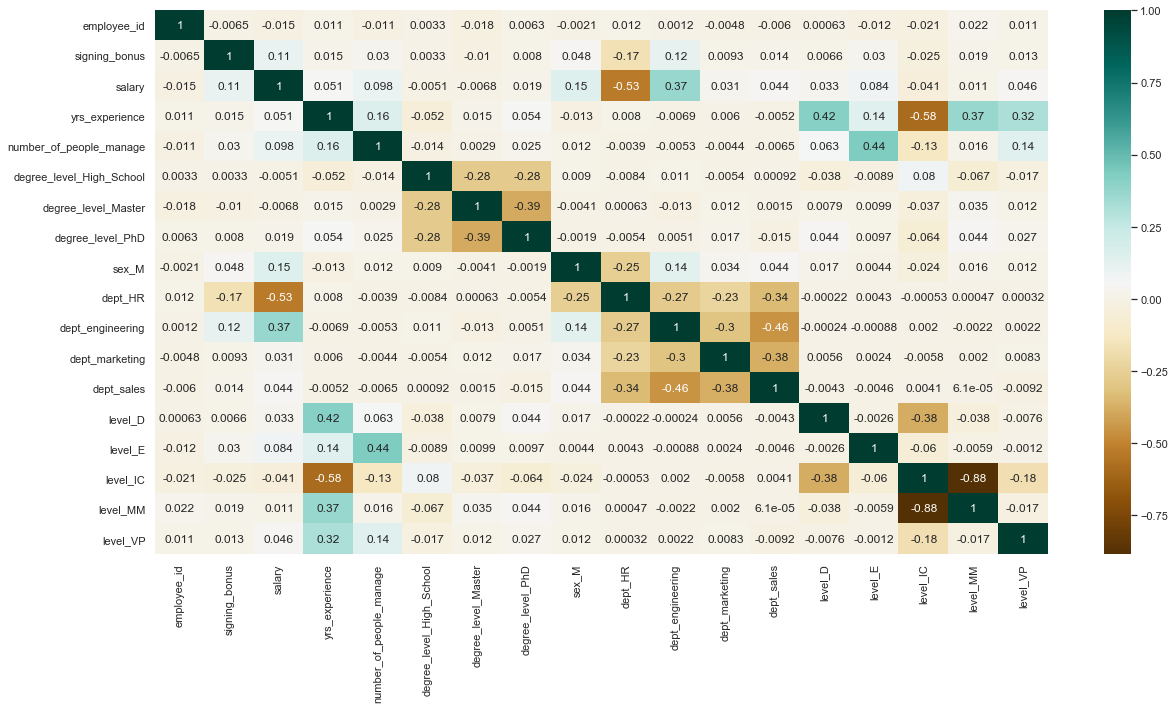

In [112]:
##Did an exploratory analysis to find out the correlated variables/a quick look on the most important variable
plt.figure(figsize=(20,10))
c= mlq3.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

### We can see that based on the correlations plot, department is highly correlated to salary as compared to other variables.
### Especially for HR department and engineering department. HR department has negative impact while engineering department has positive impact.
### Gender Male has a 0.15 positive impact on salary too.

In [113]:
###Ridge, Lasso and MLR
##We tried with the multiple linear regression first
lin_reg = LinearRegression()
##Use the scaled dataset to fit to mlr
lin_reg.fit(train_x_sc,train_y)
pred = lin_reg.predict(test_x_sc)
test_set_rmse = (np.sqrt(mean_squared_error(test_y, pred)))
print(test_set_rmse)

71.9676292021576


### Note that the rmse for multiple regression model is 71.96
### Continue with Lasso and Ridge
### Set cv=5 or 10 since the 5 or 10 are known as magical number for k-fold cross validation

In [114]:
##We try out Lasso and Ridge
ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
ridge_regressor = GridSearchCV(ridge,parameters,scoring = 'neg_mean_squared_error',cv=10)
ridge_regressor.fit(train_x_sc,train_y)
ridge_pred_y = ridge_regressor.predict(test_x_sc)
ridge_mse = np.sqrt(mean_squared_error(ridge_pred_y,test_y))
print(ridge_mse) 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.30083e-17): result may not be accurate.
  overwrite_a=True).T


71.96809390798441


In [115]:
##Try out lasso##(There is change for lasso to srhink the variables to zero)
lasso = Lasso()
parameters = {'alpha':[1e-30,1e-20,1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10]}
lasso_regressor = GridSearchCV(lasso,parameters,scoring = 'neg_mean_squared_error',cv=10)
lasso_regressor.fit(train_x_sc,train_y)
lasso_pred_y = lasso_regressor.predict(test_x_sc)
lasso_mse = np.sqrt(mean_squared_error(lasso_pred_y,test_y))
print(lasso_mse) 
print(lasso_regressor.best_params_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15457255.060275119, tolerance: 4796.901305157546
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15436513.629753137, tolerance: 4788.471855074627
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15590379.08699382, tolerance: 4842.765520746269
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3196631.489089716, tolerance: 4842.765520746269
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3203983.0653265305, tolerance: 4858.659647910448
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3206141.6713797003, tolerance: 4842.34992212272
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3143073.3100887313, tolerance: 4842.34992212272
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3193676.07020301, tolerance: 4816.636330746269
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3189400.6745781973, tolerance: 4795.836365854064
  positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

72.08613636254167
{'alpha': 0.001}


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3546282.2629330456, tolerance: 5360.471400761194
  positive)


## Note that multiple regression model performs the best among all three models 

## Next we do a random forest regression to see how it performs. Perform cross validation by GridSearchCv
## Set cv = 3 for both random forest regression and xgboost is because these two models take relatively longer time to run

In [117]:
##RandomForestRegressor do not need to use the scaled dataset
##Firstly use random forest regression
rf = RandomForestRegressor()
##Do hyperparameter tuning and cross validations
# Number of trees in random forest

# Create the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [70,80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# 10 
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_x, train_y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  7.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [125]:
#Choose the best parameters and use it to predict
best_grid = grid_search.best_estimator_
##Use the best parameter to fit 
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                        criterion='mse', max_depth=None,
                        max_features='auto',
                        max_leaf_nodes=None,
                        max_samples=None,
                        min_impurity_decrease=0.0,
                        min_impurity_split=None,
                        min_samples_leaf=1,
                        min_samples_split=2,
                        min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None,
                        oob_score=False, random_state=None,
                        verbose=0, warm_start=False)
rf.fit(train_x,train_y)
rf_pred_y = rf.predict(test_x)
##Get the square root of mean squared error for the best parameter in random forest
rf_rmse = np.sqrt(mean_squared_error(test_y,rf_pred_y))

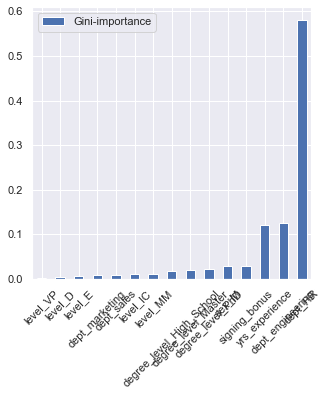

In [126]:
##Get the variables that affect salary the most from random forest regression
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(mlq3_x.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

## The results shows that HR department, engineering department and years of experience are considered as the important variables in affecting the salary

## Try out on xgboost to see how it performs use the cross validation to do further tuning
### set cv=3 since xgboost also takes longer time to run, can try on setting the cv to be 5 or 10 to see whether it performs better on the test_set next time

In [120]:
xgboostxg_reg = xgb.XGBRegressor(objective = 'reg:squarederror')
##Tune the parameters by running the cv
params ={'n_estimators': np.arange(10,50,2).tolist(),
            'eta': np.arange(0.1, 0.26, 0.05),
            'min_child_weight': np.arange(1, 5, 1).tolist(),
            'gamma': [5],
            'subsample': np.arange(0.5, 0.8, 0.11).tolist(),
            'colsample_bytree': np.arange(0.5, 1.0, 0.11).tolist()
        }
xgb_best = GridSearchCV(estimator = xgboostxg_reg,param_grid = params,cv=3)
xgb_best.fit(train_x,train_y)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.5, 0.61, 0.72, 0.83, 0.94],
                         'eta': array([0.1 , 0.15, 0.2 , 0.25]), 'gamma': [5],
                         'min_child_weight': [1, 2, 3, 4],
     

In [121]:
xgb_pred = xgb_best.predict(test_x)
xgb_rmse = np.sqrt(mean_squared_error(xgb_pred,test_y))
print(xgb_rmse)

72.14072706102759


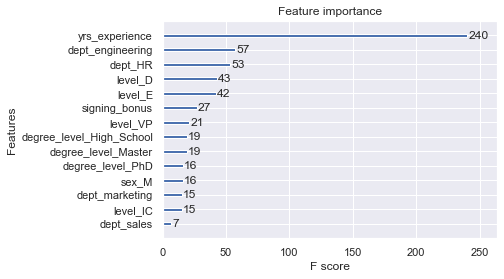

In [122]:
##Use the best performance parameter to do predicts
xgb_best = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0,
                                    subsample=1, verbosity=1)
xgb_best.fit(train_x,train_y)
xgb.plot_importance(xgb_best)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## The xgboost suggests that years of experience,department engineering and department HR are the top 3 most important variables affecting the salary

### We then decide which model performs the best, hence which model will be used

In [127]:
comp_mse = pd.DataFrame(columns=['model','rmse'])
comp_mse['model'] = ['multiple_linear_regression','ridge_regression','lasso_regression','randomforest_regression'
                    ,'xgboost']
comp_mse['rmse'] = [test_set_rmse,ridge_mse,lasso_mse,rf_rmse,xgb_rmse]
comp_mse.sort_values('rmse')


model       rmse
0  multiple_linear_regression  71.967629
1            ridge_regression  71.968094
2            lasso_regression  72.086136
4                     xgboost  72.140727
3     randomforest_regression  75.521743

### We can see that multiple linear regression performs the best, followed by ridge_regression. Lasso and xgboost has around the same mse. This might be due to different number of cv set for xgboost,random forest, lasso and ridge. However due to time constraint, I will just try out using cv=3 for random forest and xgboost. Can try out on larger numbers of CV.
### So multiple linear regression will be used to predict salary in this case.
### Random Forest Regression performs the worst.
### We can see that HR department generally has lower salary as compared to other department, while engineer department has a positive impact on the salary. 
### Hence what we can suggest is that: 
### Since we couldn't do anything to years of experiences, we can make a salary adjustment to the employees in the HR department to resolve the bias issue.

### End of assignment